# Introduction to data science
Welcome! the idea of this tutorial is to give you basic statistical and visualization tools by reprducing the analysis of this paper:

<font color='green'>

### Impact of Dietary Interventions on Pre-diabetic Oral and Gut Microbiome, Metabolites and Cytokines
Shoer et al. Nature Communications, 2023\
https://doi.org/10.1038/s41467-023-41042-x

**Abstract**\
Diabetes and associated comorbidities are a global health threat on the rise. We conducted a six-month dietary intervention in pre-diabetic individuals (NCT03222791), to mitigate the hyperglycemia and enhance metabolic health. The current work explores early diabetes markers in the 200 individuals who completed the trial. We find 166 of 2,803 measured features, including oral and gut microbial species and pathways, serum metabolites and cytokines, show significant change in response to a personalized postprandial glucose-targeting diet or the standard of care Mediterranean diet. These changes include established markers of hyperglycemia as well as novel features that can now be investigated as potential therapeutic targets. Our results indicate the microbiome mediates the effect of diet on glycemic, metabolic and immune measurements, with gut microbiome compositional change explaining 12.25% of serum metabolite variance. Although the gut microbiome displays greater compositional changes compared to the oral microbiome, the oral microbiome demonstrates more changes at the genetic level, with trends dependent on environmental richness and species prevalence in the population. In conclusion, our study shows dietary interventions can affect the microbiome, cardiometabolic profile and immune response of the host, and that these factors are well associated with each other, and can be harnessed for new therapeutic modalities.

<font color='green'>

**Introduction**\
Pre-diabetes, a condition characterized by elevated blood glucose levels but below diabetes thresholds, is a significant risk factor for the development of type 2 diabetes, as well as other comorbidities including cardiovascular and kidney diseases 1. The prevalence of pre-diabetes has risen dramatically in recent decades, affecting approximately 7.5% of the world’s population, corresponding to ~374 million individuals, the majority of whom live in low-income countries and are unaware of their condition 2.

Diet plays a critical role in the development of hyperglycemia and the onset of pre-diabetes. Poor nutrition high in processed meat, low-quality carbohydrates and sugary drinks, and low in plant-based foods, can lead to an inflammatory immune response that damages pancreatic beta cells and causes insulin insufficiency 3 4. Glycemic dysregulation is linked with various metabolic pathways and processes, including proteolysis, mitochondrial function, gluconeogenesis, de novo lipogenesis and fatty acid oxidation 5. Increasing evidence suggests there is high interpersonal variability in post-meal glucose response and that universal recommendations have limited utility 6. Zeevi et al. devised a machine-learning algorithm that integrates blood parameters, dietary habits, anthropometrics, physical activity and gut microbiota, that can accurately predict personalized postprandial glycemic response to real-life meals 7.

The gut microbiome is believed to play a mediating role in the relationship between diet, metabolism and immunity, by extracting energy from foods otherwise indigestible by the host and producing metabolites and cytokines 8 9 10. The oral microbiome has been linked with hyperglycemia because the high glucose levels provide a favorable environment for bacterial growth and can lead to chronic inflammation in periodontal tissues 11 12. The local inflammation can facilitate the passive transfer of bacterial-mediators to the circulation and induce systemic inflammation which in-turn exacerbates the insulin insufficiency 11 13.

To date, the majority of microbiome studies have focused on the level of species composition, however this approach has limitations. For example, it can create a false dependency between the measured features such that one species' abundance is dependent on another species' measured level, even if this is not biologically true. Moreover, bacteria are genetically heterogeneous, and even two strains of the same species can differ by up to 5% genetically, resulting in different bacterial phenotypes and effects on the host that compositional analyses may miss 14. By analyzing the microbiome from both species-composition and strain-genetic perspectives we get a more comprehensive look at the complex layers of the microbiome.

In this work we assess the impact of an algorithm-based personalized diet aimed at reducing postprandial glucose levels (PPT), as well as the standard of care mediterranean diet (MED), on the oral and gut microbiome, metabolites and cytokines in 200 pre-diabetic individuals. Our previous work has demonstrated the superiority of the PPT diet in improving the glycemic status compared to the standard of care 15. Here, we analyze the molecular data collected in this clinical trial to further understand the potential of dietary interventions in the management of pre-diabetes and the role the microbiome takes in it.

<font color='green'>

The abstract, introduction and discussion sections of the paper are included in this tutorial in full, \
however the results were often shortened and can be found in length in the paper itself: \
    https://doi.org/10.1038/s41467-023-41042-x

**If you are not familiar with jupyter notebook read this intoduction https://realpython.com/jupyter-notebook-introduction/** \
This is a CPU tutorial, no need for a GPU

# Settings

Copying the paper and data files to your folder

In [ ]:
!cp /home/projects/aihubadm/aihub_shared/ex-pre-diabetes/paper.pdf .
!cp /home/projects/aihubadm/aihub_shared/ex-pre-diabetes/*.xlsx .

Importing python packages

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
from pingouin import mediation_analysis
from statannot import add_stat_annotation
from statsmodels.regression.linear_model import OLS
from scipy.stats import pearsonr, mannwhitneyu, wilcoxon

Allow multiple outputs of a cell to be displayed

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Figure parameters (no need to understand them when starting the tutorial)

In [ ]:
rcParams['font.size'] = 12
rcParams['figure.figsize'] = (9, 6)
rcParams['savefig.dpi'] = 300
rcParams['savefig.format'] = 'png'

Study parameters (no need to understand them when starting the tutorial)

In [ ]:
colors = {
    'MED diet': 'cornflowerblue', 
    'PPT diet': 'orange',
    'Gut': 'lightpink',
    'Oral': 'mediumseagreen'}

In [ ]:
diet_order = ['PPT diet', 'MED diet']
time_point_order = ['Pre-intervention', 'Post-intervention']
env_order = ['Oral', 'Gut']
mediation_order = ['diet-species-glucose', 'diet-species-serum']

In [ ]:
# the order they are introduced in the paper
data_types = ['diet', 'gut species', 'gut pathways', 'oral species', 'oral pathways', 'metabolites', 'cytokines']

In [ ]:
alpha = 0.05  # of statistical tests

In [ ]:
def get_delta(df):
    """
    Calculates the difference in feature values between the post- and pre- intervention samples
    """
   
    pre = df.xs('Pre-intervention', level='Time Point')
    post = df.xs('Post-intervention', level='Time Point')

    return post.subtract(pre)

# 1 Data

**If you are not familiar with numpy go over this tutorial https://numpy.org/doc/stable/user/absolute_beginners.html** \
**If you are not familiar with pandas go over these tutorials https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html**

<font color='green'>
    
**Dietary interventions in pre-diabetes**\
Adults with pre-diabetes went through a dietary intervention for a duration of six months. 225 participants were randomly assigned to either a personalized postprandial glucose-targeting diet (PPT) (n=113) or a mediterranean diet (MED) (n=112). 200 participants - 100 from each arm completed the study. Participants were monitored throughout the intervention period and two follow-up periods of two weeks each. Data was collected using a variety of methods, including anthropometric measurements, self-reported food consumption logs using a smartphone application, continuous glucose monitoring device (CGM), and frequent provision of subgingival plaque, stool and serum samples. (Figure 1, Methods).

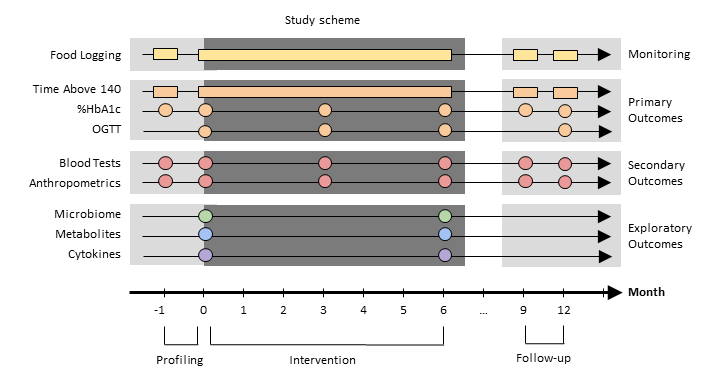

<font color='green'>

**Figure 1. Study scheme** \
The study included three periods - profiling, intervention and follow-up illustrated as a timeline (x-axis). Each row is a type of measurement processed from a specific time point (circles) or continuously (rectangles). Study defined primary outcomes are measures of glycemic response, secondary outcomes are blood tests and anthropometrics, and exploratory outcomes include the oral and gut microbiome, serum metabolites and cytokines.

Load the excel file called basic.xlsx using the pandas package

**Abbreviations:\
BMI - body mass index [kg/m^2]\
Time above 140 - daily time of blood glucose levels above 140 mg/dL [h\day]\
HbA1c - glycated hemoglobin [%]\
OGTT - oral glucose tolerance test [mg/dL*h]**

Set the Diet, Participant ID and Time Point columns as index - as these are identifiers and not actual measurements \
**Read about pandas indexing https://pandas.pydata.org/docs/user_guide/indexing.html**

Explore the data frame

Does it have the expected amount of participants mentioned in the paper? in each diet group? and in each time point?

Does it have missing values? which feature and which person have the most missing values?

Calculate the **within** person change of blood test (bt) glygcated hemoglobin (hba1c)

Compare the mean of the change in the two diet groups

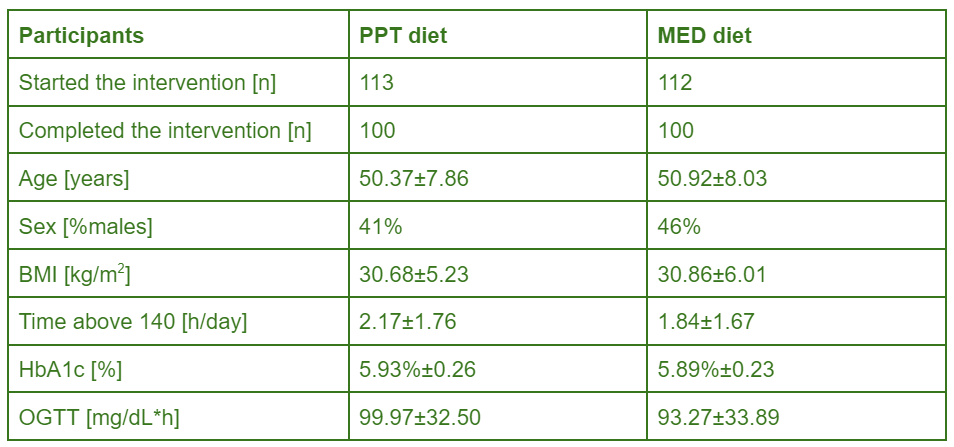

<font color='green'>

**Table 1. Baseline characteristic of study participants**

Re-create Table 1 of the paper based on "basic.xlsx", it should be based only on baseline samples (Pre-intervention) \
*its okay the sex in the PPT group is 40%

The code below loads all the data from the supplementary files, it can take a few minutes

In [ ]:
data = {}

s1 = 'Source data.xlsx'
index = ['Diet', 'Participant ID', 'Time Point']
for data_type in data_types:
    header = 12 if data_type == 'metabolites' else 0
    data[data_type] = pd.read_excel(s1, sheet_name=data_type, header=header).set_index(index)

s2 = 'Supplementary Data 1.xlsx'  # Statistical tests
index = 'feature'
for data_type in data_types:
    for diet in diet_order:
        data[f'{data_type} {diet}'] = pd.read_excel(s2, sheet_name=f'{data_type} {diet}').set_index(index)

s3 = 'Supplementary Data 2.xlsx'  # Mediation analyses
for med in mediation_order:
    suffix = env_order if 'strains' in med else diet_order
    for suf in suffix:
        data[f'{med} {suf}'] = pd.read_excel(s3, sheet_name=f'{med} {suf.split(" ")[0]}', index_col=[0, 1, 2, 3])
        
s4 = 'Supplementary Data 3.xlsx'  # Metabolites prediction
index = ['Diet', 'Participant ID', 'Time Point']
data_type = 'metabolites prediction'
data[data_type] = pd.read_excel(s4, sheet_name=data_type, header=[0, 1]).T.reset_index(0).T.set_index(index)

s5 = 'Supplementary Data 4.xlsx'  # Microbial strains
index = ['Species', 'Participant ID', 'Diet']
for env in env_order:
    data_type = f'{env.lower()} strains'
    data[data_type] = pd.read_excel(s5, sheet_name=data_type).set_index(index)

The data is saved in a dictionary, with each value being a data frame

In [ ]:
for key in data.keys():
    print(key, data[key].shape)

For example

In [ ]:
data['diet']

<font color='green'>

**Data Processing**\
Oral and gut microbiome compositional and functional data, serum metabolites and cytokines (Source data.xlsx) went through the same processing steps which included: \
    (1) Log 10 transformation \
    (2) Robust standardization using median and standard deviation calculated over 90% of the central distribution \
    (3) Outliers clipping to five standard deviations from the mean \
    (4) Features filtering out, if they exist in less than 20 samples \
    (5) Missing values imputation with feature’s minimal value only if there was a value in participant’s complementary sample (pre- or post- intervention) \
    (6) Batch correction if one of the first five principal components (PCs) explained at least 5% of the data’s variance and was significantly associated with a batch (p<0.05, Mann-Whitney U test), in a positive case it was inversely transformed and reduced from the data.

# 2 Visualization

**if you are not familiar with matplotlib pyplot go over this tutorial https://matplotlib.org/stable/tutorials/introductory/pyplot.html** \
**if you are not familiar with seaborn go over this tutorial https://seaborn.pydata.org/tutorial/introduction.html**

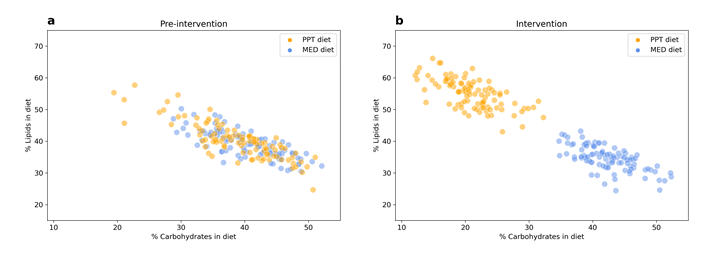

<font color='green'>

**Figure 2. Dietary interventions in pre-diabetes**\
a. Pre-intervention and b. During the intervention, percentage of carbohydrates consumed (x-axis) and percentage of lipids consumed (y-axis) in diet per participant (dot). Stratified by the dietary intervention, “PPT diet” in orange (n=100) and “MED diet” in blue (n=100). Source data are provided as a Source Data file.

Re-create Figure2 of the paper based on data['diet']
- Play with the hue_order, palette and alpha seaborn parameters
- Move the legend to each of the corners
- Set the axes limit of both sub-plots to be the same
- Read about the plt.text transform parameter

# 3 Statistical tests

**Refresh your memory on statistical tests https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2996580/ \
another resource: https://www.scribbr.com/statistics/statistical-tests/**

Which test would you chose for between diet group comparison? why?

Was the basline age, gender and BMI the same between the groups?

Which test would you chose for within diet group comparison? why?

Within each of the diet groups check if there was a signfiicant difference in the three glycemic measurments throught the trial

**Refresh your memory on multiple hypothesis correction:\
Bonferroni - https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/post-hoc/#PHbonferroni \
False discovery rate - https://www.statisticshowto.com/false-discovery-rate/**

Would your answer change if you apply Bonferroni correction?

<font color='green'>

**The PPT diet had bigger effect on the microbiome and metabolites than the MED diet**

**Microbiome** \
We performed statistical tests to compare species relative abundance at baseline versus the end of the intervention, separately for each diet. Participants in the PPT group showed a significant increase in the relative abundance of 19 gut microbiome species (Bonferroni corrected p<0.05, Wilcoxon paired signed-rank test), including seven species of the Ruminococcaceae family, four Clostridiales, three Firmicutes, two Eubacteriaceae, one Clostridiaceae, Lachnospiraceae and a species of an unclassified family. 
Participants in the MED group showed a significant increase in the relative abundance of four gut species, two from the Ruminococcaceae family and two from the Clostridiaceae family, and a significant decrease in the relative abundance of Eubacterium ventriosum (Eubacteriaceae family), consistent with literature on Mediterranean diet 23 24. None of these genomically defined species (>5% genetic difference) significantly changed in both diet groups. (Figure 3b, Supp. Fig. 1c and 1d, Source Data and Supplementary Data 1, Methods).

All the statistical tests results described in this section are in Supplementary data 1

This is the gut microbial species relative abundance data

In [ ]:
data['gut species']

The column names represent the species by their phylogentics

In [ ]:
data['gut species'].columns

First at a taxonomical level

In [ ]:
data['gut species'].columns.str.split('|').str[:7]

Looking at one species makes it more clear

In [ ]:
data['gut species'].columns.str.split('|').str[:7][0]

Second from an ID prespective

In [ ]:
data['gut species'].columns.str.split('|').str[7:]

In [ ]:
data['gut species'].columns.str.split('|').str[7:][0]

These are the significantly changed gut species in the PPT arm

In [ ]:
data['gut species PPT diet'][data['gut species PPT diet']['p_bonferroni'] < alpha]

These are the significantly changed gut species in the MED arm

In [ ]:
data['gut species MED diet'][data['gut species MED diet']['p_bonferroni'] < alpha]

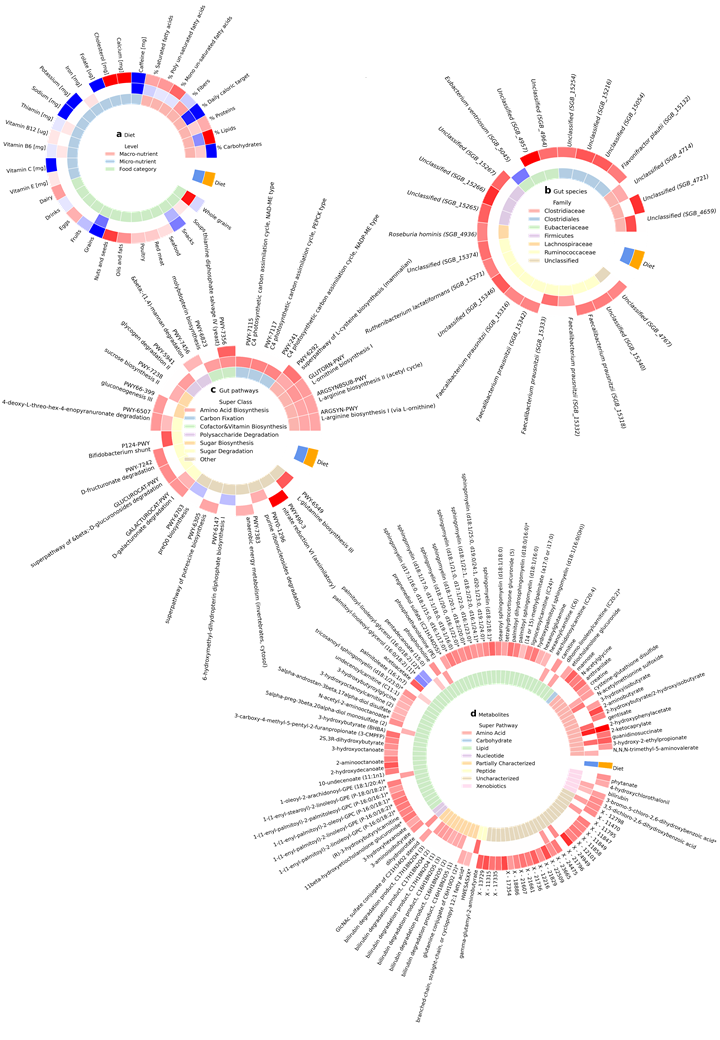

<font color='green'>

**Figure 3. The PPT diet had bigger effect on the microbiome and metabolites than the MED diet**\
a. Diet features, b. Gut microbial species, c. Gut microbial pathways and d. Serum metabolites that significantly changed in the “PPT diet” (outer ring, orange) or in the “MED diet” (middle ring, blue) (Bonferroni corrected p<0.05, two-sided Wilcoxon paired signed-rank test). Color indicates the mean change of the feature, red - increased, blue - decreased and white - not statistically significant. The inner ring is the type of dietary feature in a., the family of the species in b., the super class of the pathway in c., and the super pathway of the metabolite in d.. There was no significant difference between the two diet groups at baseline in any of the 2,803 molecular features tested (Bonferroni corrected p>0.05, two-sided Mann-Whitney U test). Source data are provided as a Source Data file.

Visualize the gut micrbiome significant results using a **bar plot** (example below), it should include:
- the diet group
- the magnitude and direction of change
- the species ID (e.g. sSGB__714)
- the species name (e.g. Methanobrevibacter smithii)

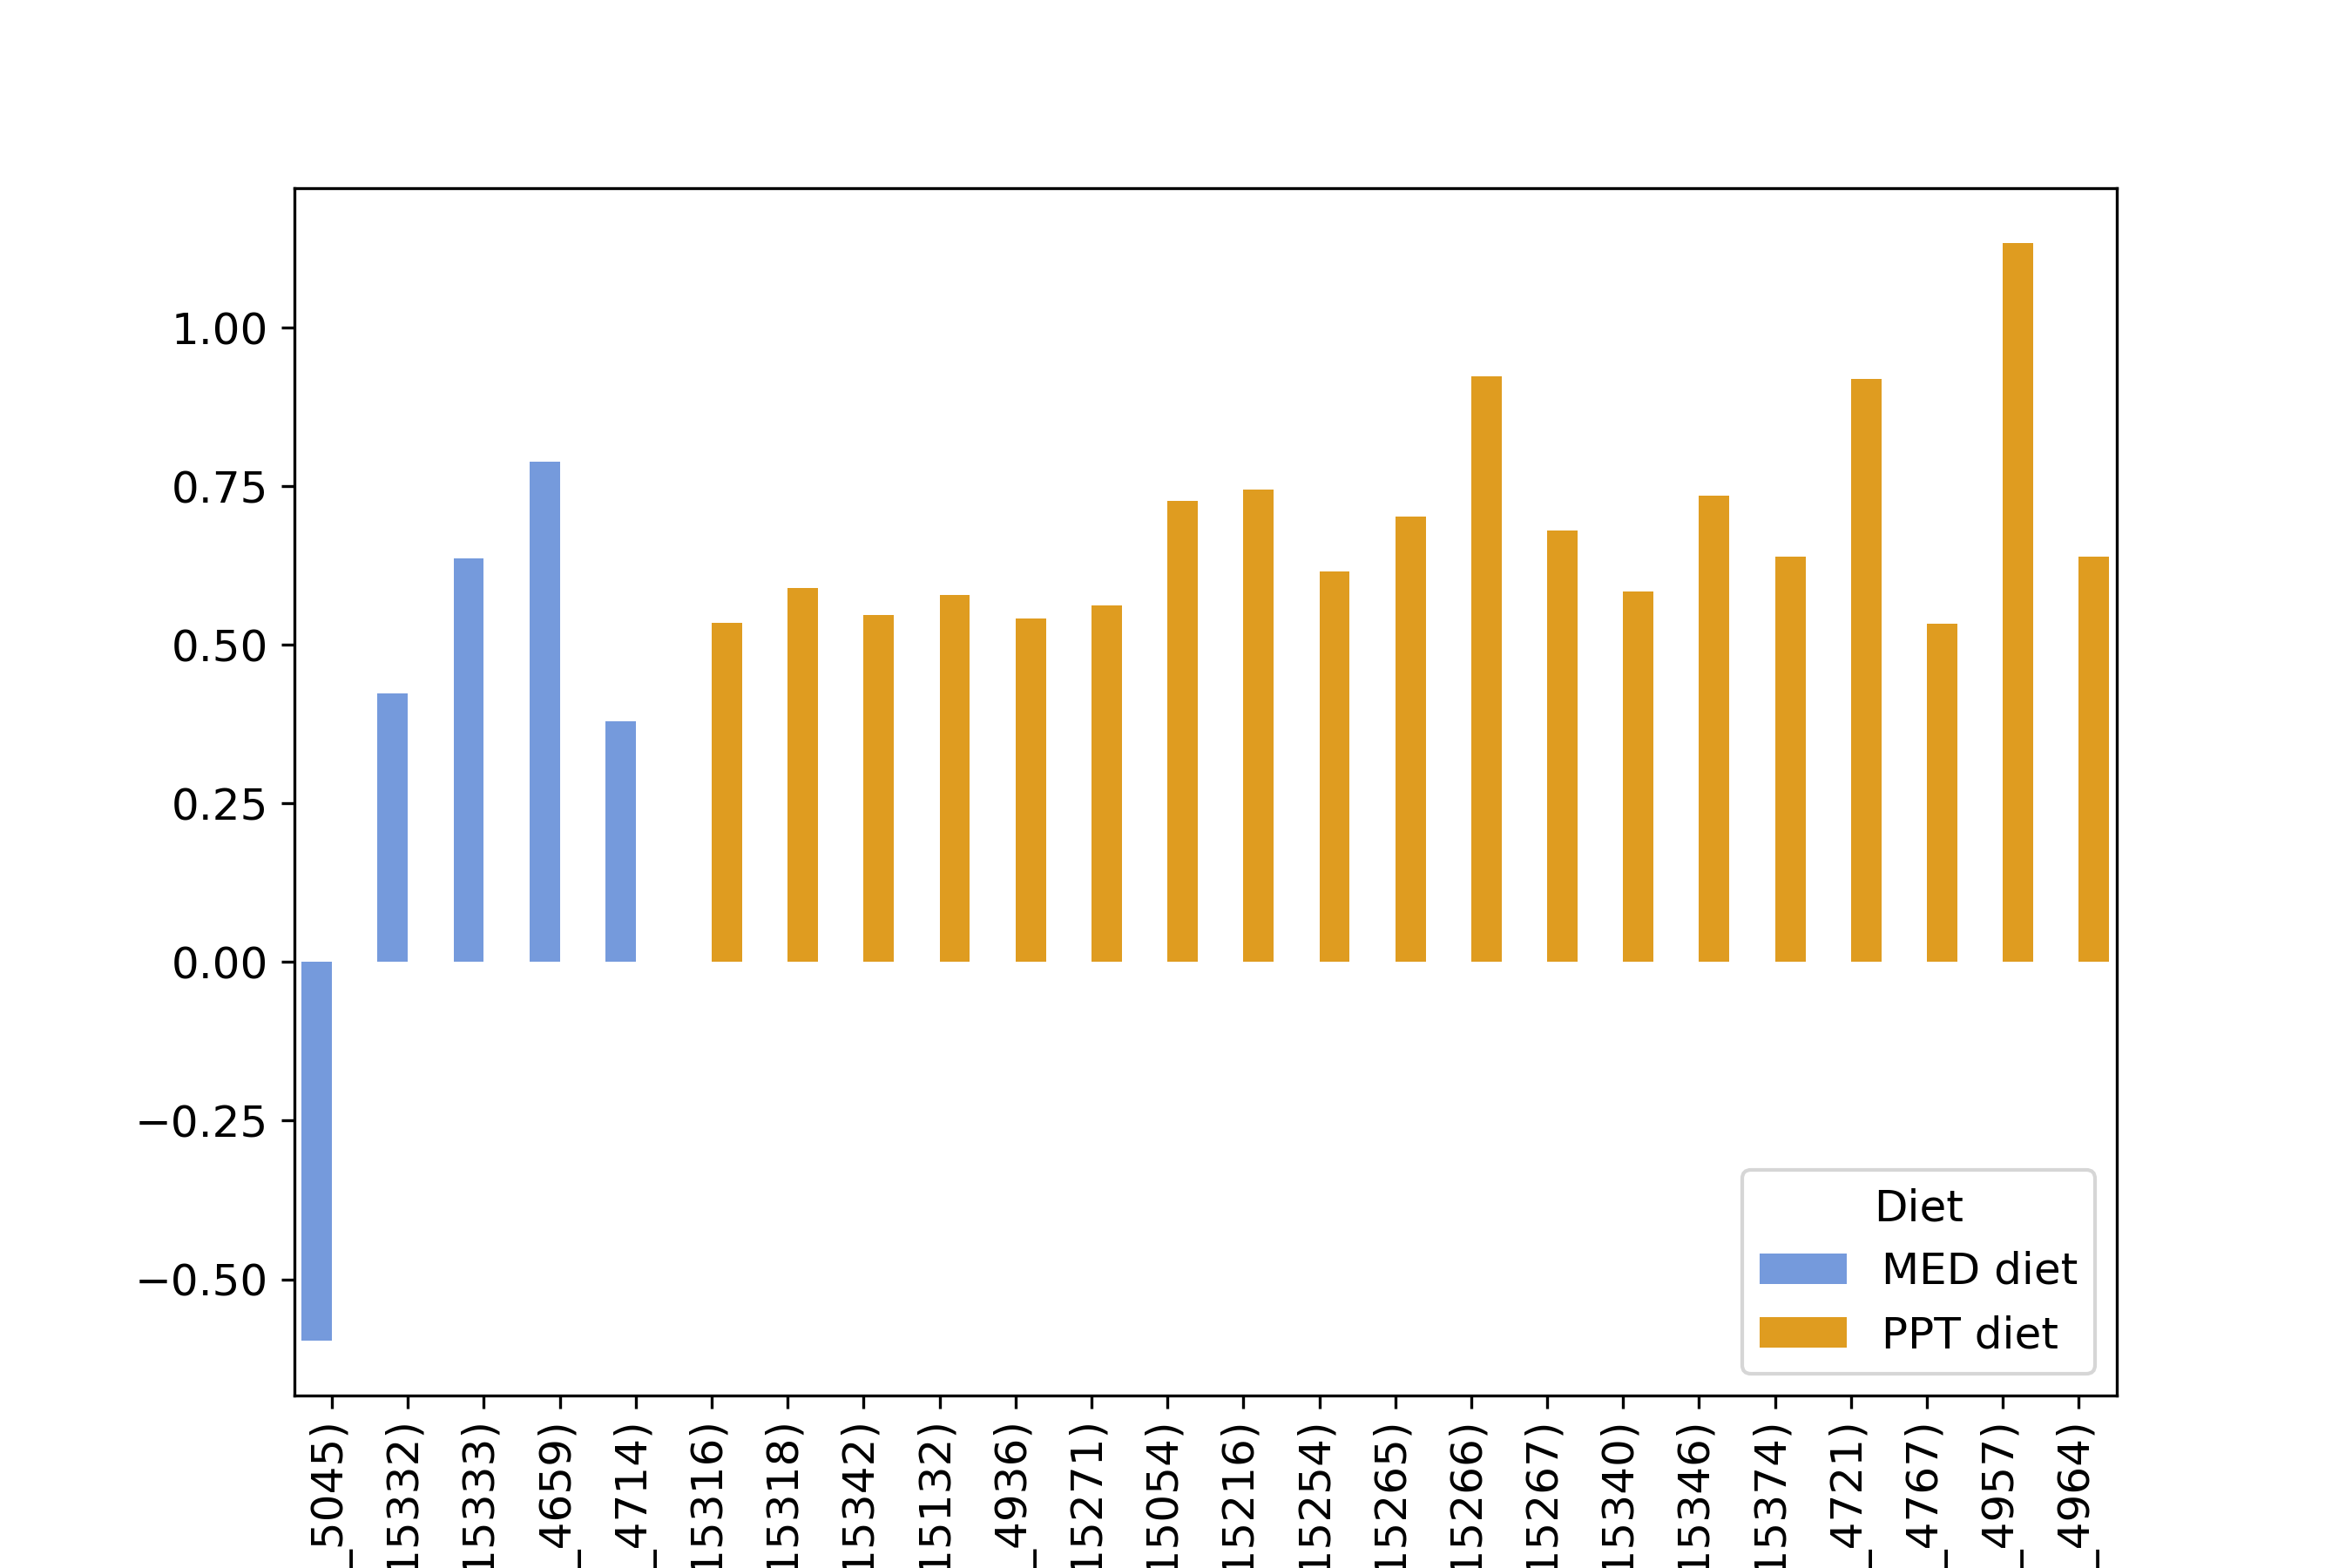

# 4 Mediation analysis

**If you are not familiar with the concept of mediation analysis read this https://data.library.virginia.edu/introduction-to-mediation-analysis/**

<font color='green'>

**The microbiome mediates the diet’s effect** \
We conducted a mediation analysis to determine whether the microbiome mediated the effects of the dietary interventions on glycemic, metabolic and immune measurements. To this end, we took all of the significantly changed features in each group and conducted a mediation analysis between the change in diet (predictor), the microbial species (mediator) and the outcome, adjusted for baseline age, sex and body mass index (BMI).

In the PPT group, four gut species mediated the effect of the diet (proteins, fibers, vitamin C, cholesterol, potassium and calcium) on the glycemic measurements of time above 140 and %HbA1c (p<0.05). Notably three of these four species are unclassified, of which one unclassified species (SGB_4957) mediated the effect of three diet features (cholesterol, potassium and calcium) on %HbA1c and another unclassified species (SGB_15054) mediated the effect of a single diet feature (vitamin C) on both glycemic measurements. F. prausnitzii (sub-type SGB_15342), the only classified species, mediated the effect of dietary proteins on time above 140. In the MED group, the effect of dietary vitamin B6 on time above 140 was mediated by a different gut F. prausnitzii (SGB_15333). (Figures 4a and 4b, Supp. Fig. 2a and 2b, Supplementary Data 2, Methods).

<font color='green'>

**Methods** \
We conducted mediation analyses only on significantly changed features in each group using pingouin (parameters: seed=42, covar=[baseline age, sex and BMI]). The diet (separately for PPT and MED) was the predictor, the oral and gut microbiome (species or pathways) were the mediators and glycemic measurements, or metabolites and cytokines were the outcomes. The change in predictor, mediator and outcome values were used. P-values were obtained using two-sided bootstrap, and a significant mediating effect was determined if the predictor had a significant effect on the mediator (M ~ X) and the mediator had a significant effect on the outcome (Y ~ X + M) (p<0.05).

Implement mediation analysis for this triad in the PPT group:\
X - % Proteins in diet\
M - Gut Faecalibacterium prausnitzii (SGB__15342)\
Y - Time above 140

Use the change in X, M and Y

Regress Y on X, is the effect of X significant?

Regress M on X, is the effect of X significant?\
Use this module https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html

Add a constant to your features (x)

Did the results change?

**Here is an explantion why:\
https://statisticsbyjim.com/regression/interpret-constant-y-intercept-regression/#:~:text=The%20constant%20term%20in%20regression,constant%20really%20is%20that%20simple**

Use the pingouin.mediation_analysis package to calculate the mediatory effect\
https://pingouin-stats.org/build/html/generated/pingouin.mediation_analysis.html#pingouin.mediation_analysis

Adjust for baseline age, sex and BMI

Did the results change?

Did you notice the pvalues are obtained using bootstrap?

**Read about bootstrap https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/**

What will happen if you increase the number of bootstrap iterations?

All the mediation analyses results described in the paper are in Supplementary data 2\
Did you get the same results as in the paper?

In [ ]:
data['diet-species-glucose PPT diet'].xs('% Proteins', level='x').xs('Faecalibacterium prausnitzii (SGB_15342)', level='m').xs('Time_above_140', level='y')

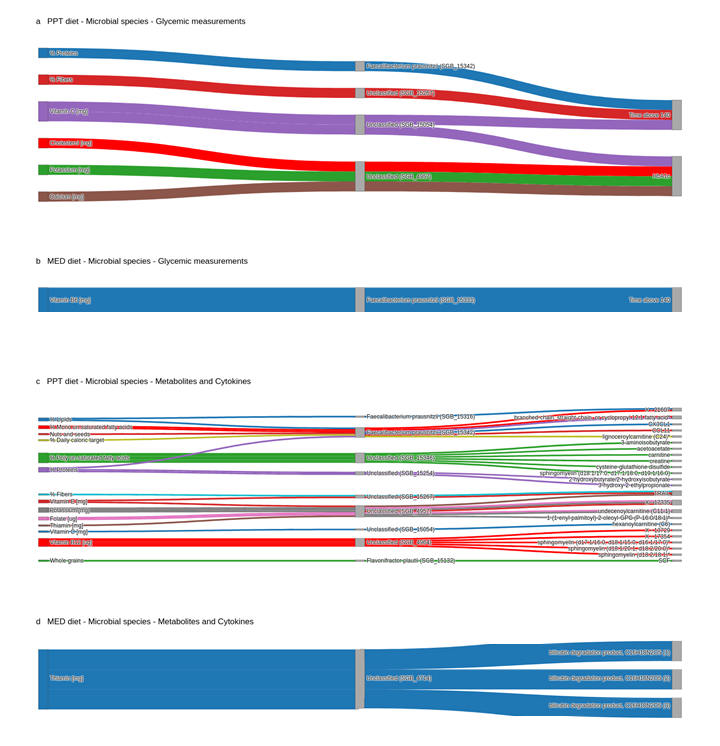

<font color='green'>

**Figure 4. The microbiome mediates the diet’s effect**\
Each alluvial plot shows paths from diet to outcomes that are mediated by oral and gut microbial species (two-sided bootstrap p<0.05). The outcomes in a. and b. are glycemic measurements, and in c. and d. the outcomes are metabolites and cytokines. a. and c. show paths of the “PPT diet”, while b. and d. show paths of the “MED diet”. Source data are provided as a Source Data file.

Visualize the significant results
- it does not have to be in the same type of figure as in the paper
- but it should include the same aspects of information

The paper uses plotly which creates interactive graphs https://plotly.com/python/

# 5 Model evaluation 

<font color='green'>

**The change in microbiome composition is associated with the change in metabolites** \
We next asked whether the changes observed in the gut microbiome and serum metabolites are associated with each other, independent of their significant level of change, nor their found mediatory role. Since we did not have enough samples to train our own model, we utilized a model previously trained to predict serum metabolites from the gut microbiome composition in a single time point observational cohort of healthy adults to predict the change in metabolites in our interventionary cohort 74 7. Model’s serum metabolites predictions were produced from the pre- and post- intervention gut microbiome species relative abundance, and then reduced from each other to quantify change. The model obtained good results (pearson r=0.35 p<10-8 between the observed and predicted change of participants from both diet groups, on metabolites with R2>0.05 in the training set), with predictions being better for the PPT diet (r=0.41 p<10-5) compared to the MED diet (r=0.18 p<0.05), despite the latter diet being more similar to that of the observational cohort (training set). Our results indicate that the change in gut microbiome composition explains a significant portion - 12.25% of the variance of change in 127 metabolites that have been previously found to be associated with the gut microbiome, including 40 uncharacterized biochemicals that can now potentially be better identified by the microbes associated with their change. For metabolites the model could not predict well in the training set (R2<0.05 in the training set), meaning they were not found to be associated with the gut microbiome, associations in this interventionary cohort still exist but to a much lower extent - 2.99% explained variance (participants from both diet groups r=0.17 p<10-10, PPT r=0.22 p<10-9, MED r=0.07 p>0.05). These findings suggest a strong association between changes in the gut microbiome composition and serum metabolites. (Figure 5, Supplementary Data 3, Methods).

<font color='green'>

**Methods** \
We used the model published by Bar et al. that was trained to predict serum metabolites from the gut microbiome composition in a single time point observational cohort to predict the change in serum metabolites in our interventionary cohort 7 74. Model’s serum metabolites predictions were produced from the pre- and post- intervention gut microbiome species relative abundance, and then reduced from each other to quantify change.

**Read about the distingtion between R2 and r^2 https://towardsdatascience.com/r%C2%B2-or-r%C2%B2-when-to-use-what-4968eee68ed3**

The model used was created as part of this paper: https://doi.org/10.1038/s41586-020-2896-2

The metabolites prediction by the microbiome described in this section are in Supplementary data 3\
Notice that the first row is the R2

In [ ]:
data['metabolites prediction']

Split the data to the well predicted metabolites (R2>0.05 in the training set) and the poorly predicted metabolites (R2<0.05)

Compute the mean predicted change in each metabolite, separtely for each diet

Compute the mean actual change in each metabolite, separtely for each diet\
Notice it has to be filtered to the samples we have predictions for

In [ ]:
data['metabolites']

Separetly for the well and for the poorly predicted metabolites, compute the expalined variance on the test set

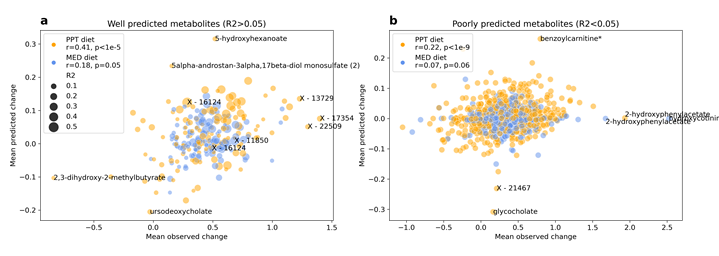

<font color='green'>

**Figure 5. The change in microbiome composition is associated with the change in metabolites** \
a. Well predicted serum metabolites by the gut microbiome (R2>0.05 in the training set) and b. Poorly predicted serum metabolites (R2<0.05 in the training set) mean observed change (x-axis) and mean predicted change (y-axis) over our study participants per metabolite (dot). Stratified by the dietary intervention, “PPT diet” in orange and “MED diet” in blue, and sized in A by the coefficient of determination (R2) of each metabolite in the training set. r, p in the legend - Pearson correlation between the mean observed and mean predicted change in each diet.

Plot the results

# 6 Sample size

<font color='green'>

**The oral microbiome is genetically more dynamic than the gut microbiome** \
Our study is unique in having both oral and gut microbiome samples before and after dietary interventions. Our results show that the gut microbiome experienced greater change at the compositional level compared to the oral microbiome. To further investigate the difference between the environments, we assessed the genetic level of microbial strains, as two strains of the same species can differ in their genetic makeup by up to 5% 14, leading to distinct phenotypes and impacts on the host that can be missed by compositional analyses.

We defined a strain replacement event for each species based on the genetic similarity between the pre- and post- intervention samples. This measurement could be aggregated at the participant level, indicating the percentage of species replaced for each individual, or at the species level, indicating the percentage of individuals who had a particular species replaced (out of those who had it). We did not find a statistically significant difference between the diets in the gut nor the oral environments (p>0.05, Mann-Whitney U test). Accordingly, we aggregated the two diets together and found that the oral microbiome was significantly more genetically dynamic than the gut microbiome, both at the participant and species levels (p<10-23, Mann-Whitney U test). Since the gut environment is richer than the oral environment (for example, before the intervention participants had 200.47±57.95 species in the gut and 167.65±34.27 species in the oral cavity p<10-9, Wilcoxon paired signed-rank test) this result could stem from different quantities available for comparison. However, the findings held even when controlling for the differences in quantity between the environments (p<0.05 in all bins, Mann-Whitney U test). (Figure 6, Supplementary Data 4, Methods).

Additionally, we observed that the richness of the oral environment correlated with increased stability of oral strains (pearson r=-0.49 between the percentage of strains replaced and environment’s richness, p<10-10) and that as the prevalence of an oral species increased, its strains tended to be more replaced (r=0.43 between the percentage of strains replaced and species prevalence in the population, p<10-11). In the gut environment, only the first trend was observed and to a lesser extent (r=-0.22, p<0.005 and r=0.05, p>0.05, respectively). These results suggest that richer environments are more stable both by the correlation to the number of species in each environment and by comparing the trend’s magnitude in the oral environment to that of the richer gut environment (r=-0.49 versus r=-0.22). The higher strain dynamics of prevalent oral species can be explained by their increased exposure to competing strains from other people, and the lack of trend seen in the gut by our constant exposure to other people's saliva but almost no exposure to other people's feces. In addition, even if there is an exposure to gut-colonizing species, they do not necessarily survive the acidic environment in the stomach.

Of the species present in at least 50 participants, the three most replaced species in the gut environment were Roseburia intestinalis, Roseburia inulinivorans and an unclassified clostridium species (SGB_4910), with replacement rates of 30.85-20.45% of participants. In the oral environment the most replaced species were Actinomyces naeslundii, Fusobacterium nucleatum and Leptotrichia buccalis, with the much higher replacement rates of 58.59-52.25% of participants. R. intestinalis and R. inulinivorans are known to metabolize human diet components and produce short-chain fatty acids, especially butyrate, which was part of nine compounds that significantly increased in the PPT group, influencing colonic immunity, inflammation and energy homeostasis. Modifications of these two species have been linked with diabetes, and R. intestinalis potential therapeutic role have been demonstrated in various studies 75 76 77 78 79. A. naeslundii is known for its various strains differing in their capabilities and its ability to modulate glucose and lactate metabolism according to its surroundings. For example, it does so according to the carbohydrate concentration, which significantly changed in this study. In certain conditions in the gingival sulcus (space between a tooth and the surrounding gingival tissue) one of its metabolic end-products, succinate, was shown to disturb the host immune system 80. Guanidino-succinate is one of the few metabolites that increased in both diet groups. A. naeslundii is negatively associated with pre-diabetes 81 while F. nucleatum is positively associated with diabetes. F. nucleatum is a main perio-pathogenic bacteria that induces chronic inflammation of periodontal tissue around the teeth and alveolar bone loss. The bacteria induces peptide secretion that modulates the immune response and certain strains of the species inflict periodontal diseases such as gingivitis and periodontitis, common in diabetes. In mice, F. nucleatum-induced periodontitis was shown to enhance insulin resistance 82 83 84 85.

The data used in this section comes from Supplementary Data 4

In [ ]:
data['gut strains']

Aggregate the results to the species level - i.e. how many people had a species? and how many of those who had it had a "strain replacement"?

Which species had the most strain replacements? anything looks funny to you?

Look only at species that exist in at least 50 people, does your answer change?

**Read about the law of small numbers https://psychology.iresearchnet.com/social-psychology/decision-making/law-of-small-numbers/#:~:text=The%20law%20of%20small%20numbers,at%20all%2C%20but%20a%20fallacy.**

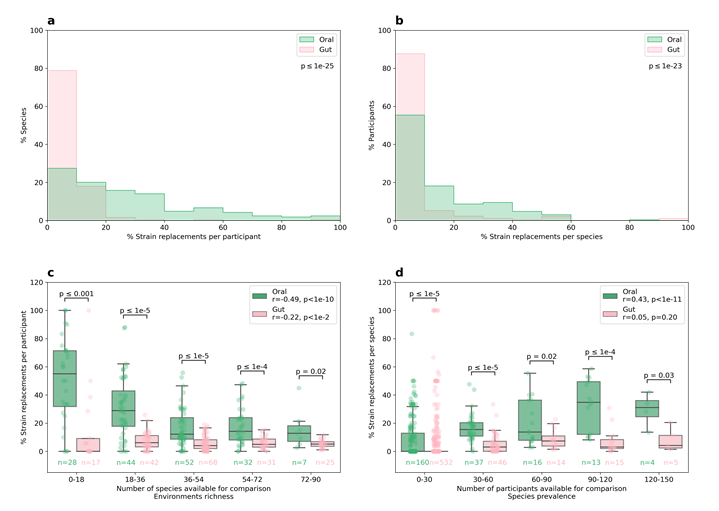

<font color='green'>
    
**Figure 6. The oral microbiome is genetically more dynamic than the gut microbiome** \
Normalized histograms of the percentage of strains replaced a. per participant and b. per species. Percentage of strains replaced c. per participant and d. per species (y-axis), binned by the number of species or participants available for comparison, respectively (x-axis). Boxes show the quartiles of the data (0.25, 0.50, 0.75) while the whiskers extend to 1.5 of the inter quartile range, points beyond the whiskers are considered to be outliers. All panels are stratified by the environment, “Oral” in green and “Gut” in pink. p below the legends in the upper panels and on top of the boxes in the lower panels is between the oral and gut percentage of strains replaced (two sided Mann-Whitney U test). r, p in the legend - Pearson correlation between the percentage of strains replaced and the quantity available for comparison in each environment. n below the boxplot - number of participants or species in each bin and environment.

**Read about the statannot.add_stat_annotation python package, it can save you a lot of time https://github.com/webermarcolivier/statannot/blob/master/example/example.ipynb**

Re-create Figure6 c of the paper

<font color='green'>

**Discussion** \
In this work, we evaluated the impact of two different dietary interventions on the microbiome, metabolites and cytokines of 200 pre-diabetic individuals (100 from each arm). Both diets, the standard-of-care Mediterranean (MED) diet and a personalized algorithm-based postprandial glucose-targeting (PPT) diet, have previously been shown to positively impact glucose response 15.

Participants assigned to the PPT diet showed significant changes in 19 gut microbial species, 14 gut and one oral microbial pathways, 86 serum metabolites and four cytokines. Participants assigned to the MED diet showed significant changes in five gut and one oral microbial species, 18 gut microbial pathways, 27 metabolites and four cytokines. Some of these changes have been previously linked with hyperglycemia, such as the gut species F. prausnitzii that is negatively associated with insulin resistance and five of its sub-types have significantly increased among the study participants 36 37 38 39 40. Another example is thiamin (vitamin B1) biosynthesis gut microbial pathway that significantly increased in both diet groups and has a direct impact on carbohydrate metabolism 49. The PPT group showed an increase in nine butyrate-containing compounds that have positive effects on glucose-homeostasis, and in the cytokine TRAIL that protects against diabetes by modulating the immune system 52 53 54 55 67. The MED group showed an increase in bilirubin and five of its degradation products, which is negatively associated with diabetes, and in the cytokine SIRT2 that inhibits gluconeogenesis 59–64 . Other changes that were not previously associated with hyperglycemia, especially of unclassified species and uncharacterized biochemicals, could potentially be new early markers for diabetes.

Mediation analyses showed the gut microbiome composition both at the level of species and at the level of pathways takes a significant role in modulating the diet’s effect on glycemic, metabolic and immune measurements. For example at the glycemic level, F. prausnitzii (sub-type SGB_15342) mediated the effect of dietary proteins on the daily time of blood glucose levels above 140 mg/dL (“time above 140”) in the PPT group, and in the MED group a different F. prausnitzii (sub-type SGB_15333) mediated the effect of dietary vitamin B6 on the same glycemic measurement, indicating the possibility of a strain level difference. At the metabolites level, the effect of dietary vitamin B12 on sphingomyelins was mediated by an unclassified species (SGB_4964) in the PPT group, and the effect of dietary thiamin on bilirubin degradation products was mediated by another unclassified species (SGB_4714) in the MED group. At the cytokines level, in the PPT group F. prausnitzii (sub-type SGB_15342) mediated the diet’s effect on CX3CL1 and CCL11. One unclassified species (SGB_4957) mediated the effect of thiamin on TRAIL, and another unclassified species (SGB_15267) mediated the effect of dietary fibers and vitamin E on TRAIL. In the MED group we did not find such mediating effects on the immune system. These results can be utilized for novel therapeutics modalities by future mechanistic studies.

A predictive model also demonstrated the significant relationship between changes in gut microbiome composition and changes in serum metabolites and showed that 12.25% of the variance in the change of 127 metabolites can be explained by changes in species composition.

We find that while the gut microbiome was more dynamic than the oral microbiome at the compositional level in this study, the opposite was true at the strain-genetic level. High genetic dynamics of microbial species was found to be negatively associated with environmental richness and positively associated with oral species prevalence. This may be due to higher exposure to competitive strains, such as pathogenic F. nucleatum strains that induce periodontitis and enhance insulin resistance 85. We show this genetic level also has a mediatory role in the diet’s effect on various measurements. For example, the species with the most strain replacements in the gut environment R. intestinalis mediated the effect of caffeine on sphingomyelins and butyrate, and the corresponding species in the oral environment A. naeslundii mediated the effect of drinks on butyrate and the glycemia.

In conclusion, our study shows that dietary interventions can significantly impact the oral and gut microbiome, serum metabolites and glycemic regulation, and that these factors are well associated with each other. In the future, following extensive progress in the field, diets such as the personally tailored postprandial glucose-targeting one in this study, which takes into account microbiome features, could be designed to affect the microbiome and inflict desired metabolic outcomes. This can be especially useful for microbiome-related metabolites such as bilirubin that is known to be beneficial but is difficult to synthetically synthesize and efficiently deliver 62. Dietary interventions, as effective as they are, require high motivation and adherence that do not always exist, methods such as probiotics and fecal microbiota transplants (FMTs) may also be used for the same purpose. Furthermore, probiotics and FMTs can be superior to dietary intervention in affecting the microbiome, as they allow for the introduction of specific strains with desired capabilities.

Well done! you finihed the tutorial